In [1]:
from coreLib.dataset import DataSet
data_dir       = "/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source"
ds=DataSet(data_dir)
ds.bangla.graphemes.csv

#LOG     :All paths found
#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/bangla/dictionary.csv


  0%|          | 0/1059977 [00:00<?, ?it/s]

#LOG     :converting int labels to string


  0%|          | 0/10305 [00:00<?, ?it/s]

#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/english/dictionary.csv


  0%|          | 0/370098 [00:00<?, ?it/s]

#LOG     :bangla.graphemes


  0%|          | 0/200840 [00:00<?, ?it/s]

#LOG     :bangla.numbers


  0%|          | 0/72045 [00:00<?, ?it/s]

#LOG     :english.graphemes


  0%|          | 0/46101 [00:00<?, ?it/s]

#LOG     :english.numbers


  0%|          | 0/10305 [00:00<?, ?it/s]

#LOG     :common.symbols


  0%|          | 0/5975 [00:00<?, ?it/s]

#LOG     :bangla.fonts


  0%|          | 0/21 [00:00<?, ?it/s]

#LOG     :english.fonts


  0%|          | 0/2682 [00:00<?, ?it/s]

#LOG     :common.background


  0%|          | 0/982 [00:00<?, ?it/s]

#LOG     :common.noise.random


  0%|          | 0/112763 [00:00<?, ?it/s]

#LOG     :common.noise.sign


  0%|          | 0/3240 [00:00<?, ?it/s]

'/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/bangla/graphemes.csv'

bangla handwritten grapheme True


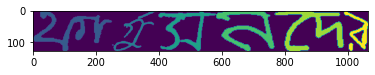

{2: 'ফা', 3: 'র্গু', 4: 'স', 5: 'ন', 6: 'দে', 7: 'র'}
[0 2 3 4 5 6 7]
bangla handwritten grapheme False


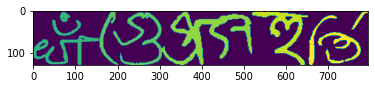

{8: 'খাঁ', 9: 'ণ্ডে', 10: 'প্র্যা', 11: 'হু', 12: 'র্তি'}
[ 0  8  9 10 11 12]
bangla handwritten number True


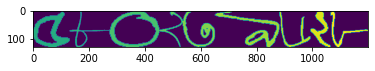

{13: '৫', 14: '৮', 15: '০', 16: '২', 17: '৩', 18: '৯', 19: '৬', 20: '২', 21: '৮'}
[ 0 13 14 15 16 17 18 19 20 21]
bangla handwritten number False


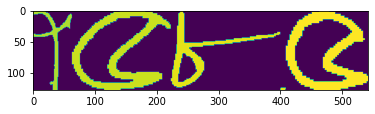

{22: '৭', 23: '৫', 24: '৮', 25: '৫'}
[ 0 22 23 24 25]
bangla printed grapheme True


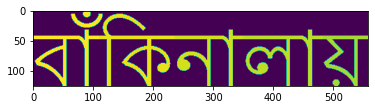

{26: 'বাঁ', 27: 'কি', 28: 'না', 29: 'লা', 30: 'য়'}
[ 0 26 27 28 29 30]
bangla printed grapheme False


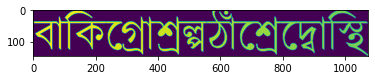

{31: 'বা', 32: 'কি', 33: 'গ্রো', 34: 'শ্র', 35: 'ল্প', 36: 'ঠাঁ', 37: 'শ্রে', 38: 'দ্বো', 39: 'স্থি'}
[ 0 31 32 33 34 35 36 37 38 39]
bangla printed number True


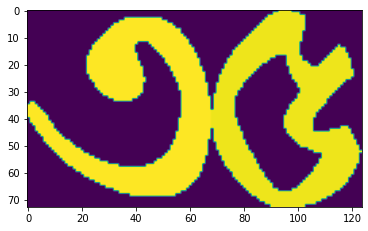

{40: '৩', 41: '৫'}
[ 0 40 41]
bangla printed number False


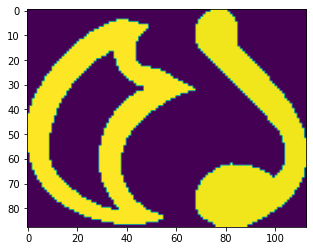

{42: '৫', 43: '১'}
[ 0 42 43]
english handwritten grapheme True


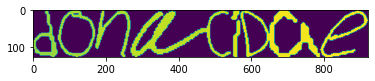

{44: 'd', 45: 'o', 46: 'n', 47: 'a', 48: 'c', 49: 'i', 50: 'd', 51: 'a', 52: 'e'}
[ 0 44 45 46 47 48 49 50 51 52]
english handwritten grapheme False


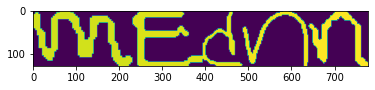

{53: 'm', 54: 'e', 55: 'd', 56: 'n', 57: 'n'}
[ 0 53 54 55 56 57]
english handwritten number True


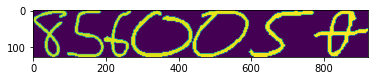

{58: '8', 59: '5', 60: '6', 61: '0', 62: '0', 63: '5', 64: '0'}
[ 0 58 59 60 61 62 63 64]
english handwritten number False


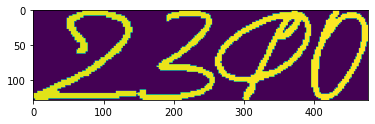

{65: '2', 66: '3', 67: '0', 68: '0'}
[ 0 65 66 67 68]
english printed grapheme True


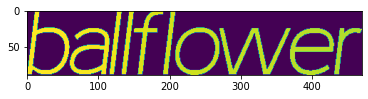

{69: 'b', 70: 'a', 71: 'l', 72: 'l', 73: 'f', 74: 'l', 75: 'o', 76: 'w', 77: 'e', 78: 'r'}
[ 0 69 70 71 72 73 74 75 76 77 78]
english printed grapheme False


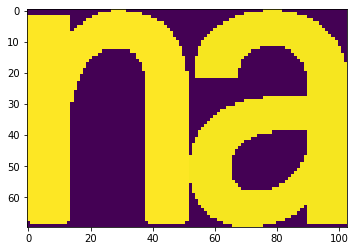

{79: 'n', 80: 'a'}
[ 0 79 80]
english printed number True


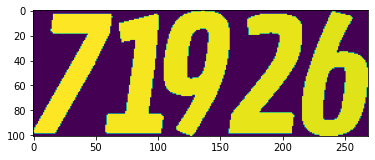

{81: '7', 82: '1', 83: '9', 84: '2', 85: '6'}
[ 0 81 82 83 84 85]
english printed number False


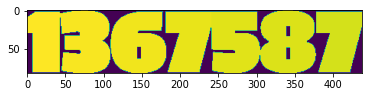

{86: '1', 87: '3', 88: '6', 89: '7', 90: '5', 91: '8', 92: '7'}
[ 0 86 87 88 89 90 91 92]


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
iden=2
from coreLib.word import create_word
'''
source_type             :       bangla/english 
data_type               :       handwritten/printed                  
comp_type               :       grapheme/number
'''
for source in ["bangla","english"]:
    for data in ["handwritten","printed"]:
        for comp in ["grapheme","number"]:
            for ud in [True,False]:
                
                print("=========================================")
                print(source,data,comp,str(ud))
                img,label,iden=create_word(iden,
                                source,
                                data,
                                comp,
                                ds,
                                use_dict=ud)
                plt.imshow(img)
                plt.show()
                print(label)
                print(np.unique(img))
                print("=========================================")


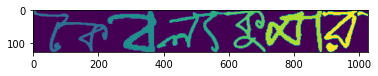

{3: 'কৈ', 4: 'ব', 5: 'ল্য', 6: 'কু', 7: 'মা', 8: 'র'}


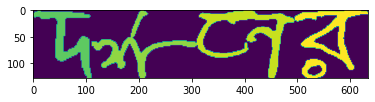

{9: 'দ', 10: 'র্শ', 11: 'ণে', 12: 'র'}


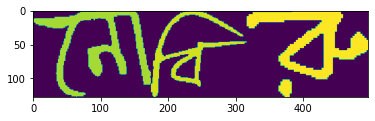

{13: 'নো', 14: 'বি', 15: 'রু'}


In [131]:
imgs=[]
labels=[]
w_max=0
h_max=0
iden = 3
for _ in range(3):
    img,label,iden=create_word(iden,
                                "bangla",
                                "handwritten",
                                "grapheme",
                                ds,
                                use_dict=True)
    plt.imshow(img)
    plt.show()
    h,w=img.shape
    if w>w_max:
        w_max=w
    if h>h_max:
        h_max=h
    print(label)
    imgs.append(img)
    labels.append(label)

# Problem-1: ৩ টার ভ্যালু মার্জ হয়ে যাইতেছে  (dashed charecters are being created)

{3: 'কৈ', 4: 'ব', 5: 'ল্য', 6: 'কু', 7: 'মা', 8: 'র'}


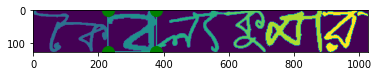

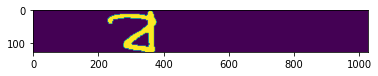

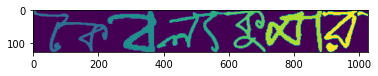

[array([ 33.61577262, 563.32437416]), array([162.65355779, 488.82437416]), array([226.15355779, 598.80960044]), array([ 97.11577262, 673.30960044])]


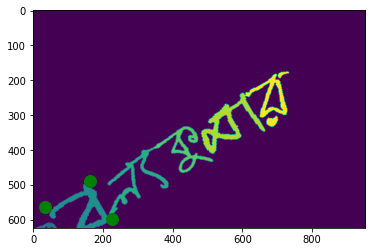

[[ 47. 178.]
 [732. 178.]
 [732. 623.]
 [ 47. 623.]]


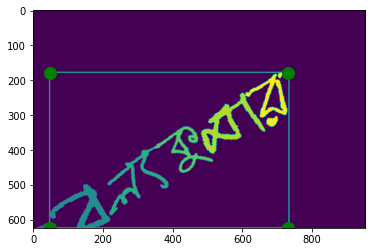

In [133]:
img=imgs[0]
print(labels[0])
back=np.zeros(img.shape)
back[img==4]=255
img1=img.copy()
# co-ordinate
idx = np.where(img==4)
y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
x1,x2,x3,x4=x_min,x_max,x_max,x_min
y1,y2,y3,y4=y_min,y_min,y_max,y_max
coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")

img1 = cv2.rectangle(img1, (x1,y1), (x3,y3), 5, 2)
plt.imshow(img1)
plt.plot(x1, y1, 'go--', linewidth=2, markersize=12)
plt.plot(x2, y2, 'go--', linewidth=2, markersize=12)
plt.plot(x3, y3, 'go--', linewidth=2, markersize=12)
plt.plot(x4, y4, 'go--', linewidth=2, markersize=12)

plt.show()

plt.imshow(back)
plt.show()
plt.imshow(img)
plt.show()

# get shape
(h, w) = img.shape
# get center
center = (w / 2, h / 2)
# angle to rotate
angle  = 30
# get rotation matrix
M = cv2.getRotationMatrix2D(center, angle, 1.0)
# Now will take out sin and cos values from rotationMatrix
# Also used numpy absolute function to make positive value
cosM = np.abs(M[0][0])
sinM = np.abs(M[0][1])
# Now will compute new height & width of
# an image so that we can use it in
# warpAffine function to prevent cropping of image sides
nH = int((h * sinM) +(w * cosM))
nW = int((h * cosM) +(w * sinM))

# After computing the new height & width of an image
# we also need to update the values of rotation matrix
M[0][2] += (nW/2) - center[0]
M[1][2] += (nH/2) - center[1]
# rotate
img = cv2.warpAffine(img, M, (nH,nW))


new_coords=[]
coord_mat=np.concatenate([coords,np.ones((4,1))],axis=1)
for c in coord_mat:
    new_coords.append(np.dot(M,c))
print(new_coords)
for c in new_coords:
    plt.plot(c[0], c[1], 'go--', linewidth=2, markersize=12)

plt.imshow(img)
plt.show()

img1=img.copy()
# co-ordinate
idx = np.where(img==4)
y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
x1,x2,x3,x4=x_min,x_max,x_max,x_min
y1,y2,y3,y4=y_min,y_min,y_max,y_max
print(np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32"))

img1 = cv2.rectangle(img1, (x1,y1), (x3,y3), 5, 2)
plt.imshow(img1)
plt.plot(x1, y1, 'go--', linewidth=2, markersize=12)
plt.plot(x2, y2, 'go--', linewidth=2, markersize=12)
plt.plot(x3, y3, 'go--', linewidth=2, markersize=12)
plt.plot(x4, y4, 'go--', linewidth=2, markersize=12)

plt.show()



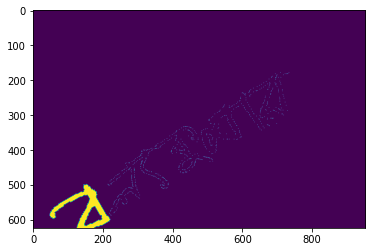

In [134]:
back=np.zeros(img.shape)
back[img==4]=255
plt.imshow(back)
plt.show()

# Problem-2: After merging various rotational images , we loose center (rotation also)

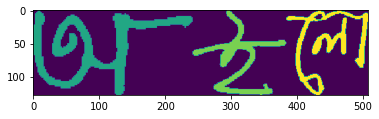

{3: 'অ', 4: 'ই', 5: 'লো'}


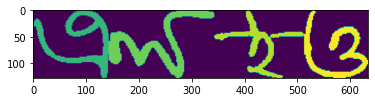

{6: 'এ', 7: 'ল', 8: 'ই', 9: 'ও'}


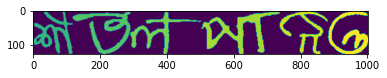

{10: 'শী', 11: 'ত', 12: 'ল', 13: 'পা', 14: 'টি', 15: 'ও'}


In [124]:
imgs=[]
labels=[]
w_max=0
h_max=0
iden = 3
for _ in range(3):
    img,label,iden=create_word(iden,
                                "bangla",
                                "handwritten",
                                "grapheme",
                                ds,
                                use_dict=True)
    plt.imshow(img)
    plt.show()
    h,w=img.shape
    if w>w_max:
        w_max=w
    if h>h_max:
        h_max=h
    print(label)
    imgs.append(img)
    labels.append(label)

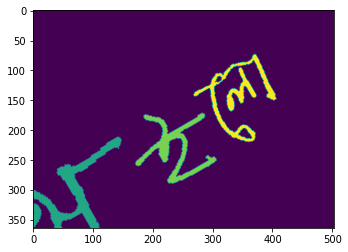

In [125]:
img=imgs[0]
# get shape
(h, w) = img.shape
# get center
center = (w / 2, h / 2)
# angle to rotate
angle  = 30
# get rotation matrix
M = cv2.getRotationMatrix2D(center, angle, 1.0)
# Now will take out sin and cos values from rotationMatrix
# Also used numpy absolute function to make positive value
cosM = np.abs(M[0][0])
sinM = np.abs(M[0][1])
# Now will compute new height & width of
# an image so that we can use it in
# warpAffine function to prevent cropping of image sides
nH = int((h * sinM) +(w * cosM))
nW = int((h * cosM) +(w * sinM))

# After computing the new height & width of an image
# we also need to update the values of rotation matrix
M[0][2] += (nW/2) - center[0]
M[1][2] += (nH/2) - center[1]
# rotate
img = cv2.warpAffine(img, M, (nH,nW))
plt.imshow(img)
plt.show()

In [126]:
imgs=[img,imgs[2],imgs[1]]


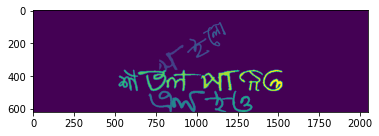

In [127]:
def padImage(img):
    '''
        pads an image with white value
        args:
            img     :       the image to pad
            pad_loc :       (lr/tb) lr: left-right pad , tb=top_bottom pad
            pad_dim :       the dimension to pad upto 
    '''    
    pad_dim=2048
    # shape
    h,w=img.shape
    # pad widths
    left_pad_width =(pad_dim-w)//2
    # print(left_pad_width)
    right_pad_width=pad_dim-w-left_pad_width
    # pads
    left_pad =np.zeros((h,left_pad_width))
    right_pad=np.zeros((h,right_pad_width))
    # pad
    img =np.concatenate([left_pad,img,right_pad],axis=1)
    return img

padded=[]
for img in imgs:
    padded.append(padImage(img))
ii=np.concatenate(padded,axis=0)
plt.imshow(ii)
plt.show()

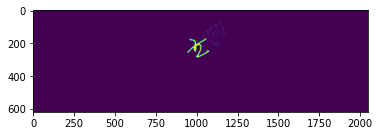

In [130]:
back=np.zeros(ii.shape)
back[ii==4]=255
plt.imshow(back)
plt.show()

# Problem-1: Value Does not stay constant for labels (dashed charecters are being created)
# Problem-2: After merging various rotational images , we loose center (rotation also)